<a href="https://colab.research.google.com/github/hiteshisawariya485/Signature_Verification/blob/main/ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.utils import class_weight

# Define dataset path
dataset_path = "C:/Users/palak/OneDrive/Desktop/College/Sem 6/Deep Learning/Research Paper/Dataset/Data"

# Load images and labels
X = []
y = []

image_size = (128, 128)  # Resizing images to 128x128

# Check all file names first to understand labeling pattern
print("Examining file names in the dataset:")
for filename in sorted(os.listdir(dataset_path))[:10]:  # Show first 10 files only
    if filename.endswith((".png", ".jpg", ".jpeg")):
        print(f"- {filename}")

# Now load the images with the correct labeling logic
for filename in os.listdir(dataset_path):
    if filename.endswith((".png", ".jpg", ".jpeg")):
        # Load image in grayscale
        img = cv2.imread(os.path.join(dataset_path, filename), cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Could not read image: {filename}")
            continue

        img = cv2.resize(img, image_size)  # Resize image
        img = img / 255.0  # Normalize pixel values to [0, 1]

        X.append(img)

        # FIXED: Use correct labels based on filename
        # Check for "original" instead of "genuine"
        if "original" in filename.lower():
            y.append(1)  # Original/Genuine signature
        else:
            y.append(0)  # Forgery

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Check class balance and distribution
print(f"\nTotal samples: {len(y)}")
print(f"Original signatures (class 1): {np.sum(y == 1)}")
print(f"Forged signatures (class 0): {np.sum(y == 0)}")
print(f"Class balance: {np.sum(y == 1) / len(y):.2f}")

# Reshape X to fit ANN input (flattening the image)
X = X.reshape(X.shape[0], -1)
print(f"Input shape after flattening: {X.shape}")

# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Training set - Original: {np.sum(y_train == 1)}, Forged: {np.sum(y_train == 0)}")
print(f"Testing set - Original: {np.sum(y_test == 1)}, Forged: {np.sum(y_test == 0)}")

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"Class weights: {class_weights_dict}")

# Build an improved ANN model
model = Sequential([
    # Input layer
    Input(shape=(X_train.shape[1],)),

    # First hidden layer
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    # Second hidden layer
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    # Third hidden layer
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Fourth hidden layer
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    # Output layer
    Dense(1, activation='sigmoid')  # Binary classification (Original/Forged)
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# Print model summary
model.summary()

# Add early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# Reduce learning rate when plateau is reached
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict,
    verbose=1
)



Examining file names in the dataset:
- forgeries_10_1.png
- forgeries_10_10.png
- forgeries_10_11.png
- forgeries_10_12.png
- forgeries_10_13.png
- forgeries_10_14.png
- forgeries_10_15.png
- forgeries_10_16.png
- forgeries_10_17.png

Total samples: 2640
Original signatures (class 1): 1320
Forged signatures (class 0): 1320
Class balance: 0.50
Input shape after flattening: (2640, 16384)

Training set size: 2112 samples
Testing set size: 528 samples
Training set - Original: 1056, Forged: 1056
Testing set - Original: 264, Forged: 264
Class weights: {0: 1.0, 1: 1.0}


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,239,745 (16.17 MB)

 Trainable params: 4,238,785 (16.17 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.7620 - loss: 0.4869 - precision: 0.7442 - recall: 0.7928 - val_accuracy: 0.5000 - val_loss: 6.2167 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9373 - loss: 0.2119 - precision: 0.9332 - recall: 0.9409 - val_accuracy: 0.5000 - val_loss: 7.9312 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9605 - loss: 0.1526 - precision: 0.9556 - recall: 0.9654 - val_accuracy: 0.5000 - val_loss: 8.6006 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.9679 - loss: 0.1212 - precision: 0.9594 - recall: 0.9764 - val_accuracy: 0.5000 - val_loss: 6.7482 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/100
6

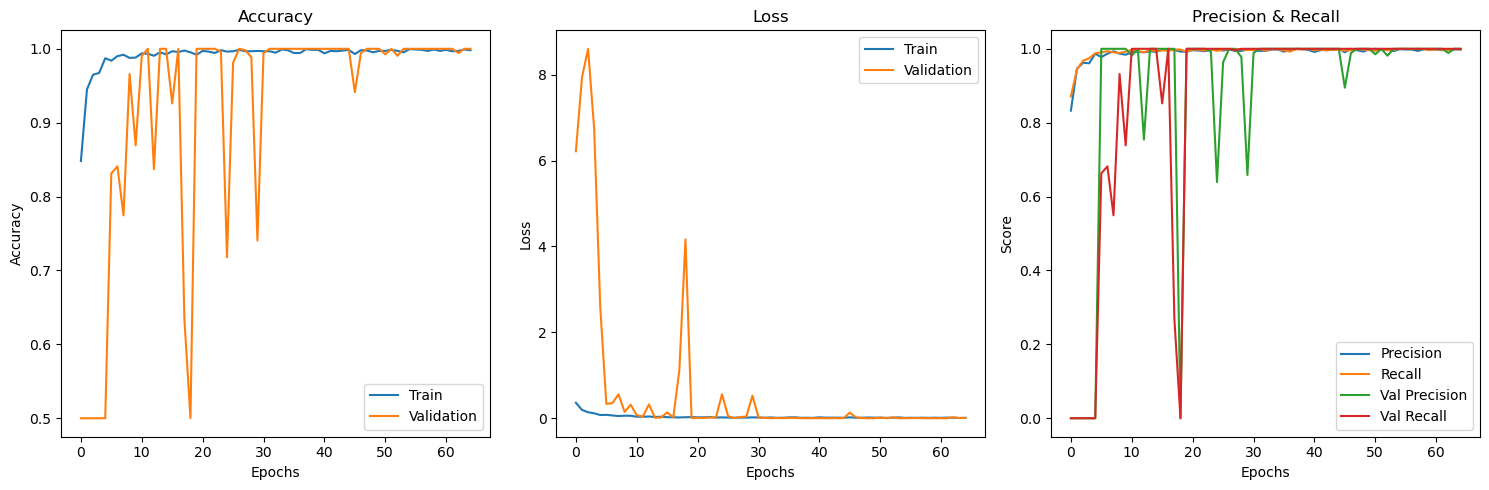


Evaluating model:
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0015 - precision: 1.0000 - recall: 1.0000
Validation Accuracy: 1.0000
Validation Loss: 0.0014
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Equal Error Rate (EER): 0.0000

Confusion Matrix:
[[264   0]
 [  0 264]]

Confusion Matrix Interpretation:
True Negatives (correctly identified forgeries): 264
False Positives (forgeries classified as original): 0
False Negatives (originals classified as forgeries): 0
True Positives (correctly identified originals): 264

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       264
           1       1.00      1.00      1.00       264

    accuracy                           1.00       528
   macro avg       1.00      1.00      1.00       528
weighted avg       1.00      1.00      1.00       528



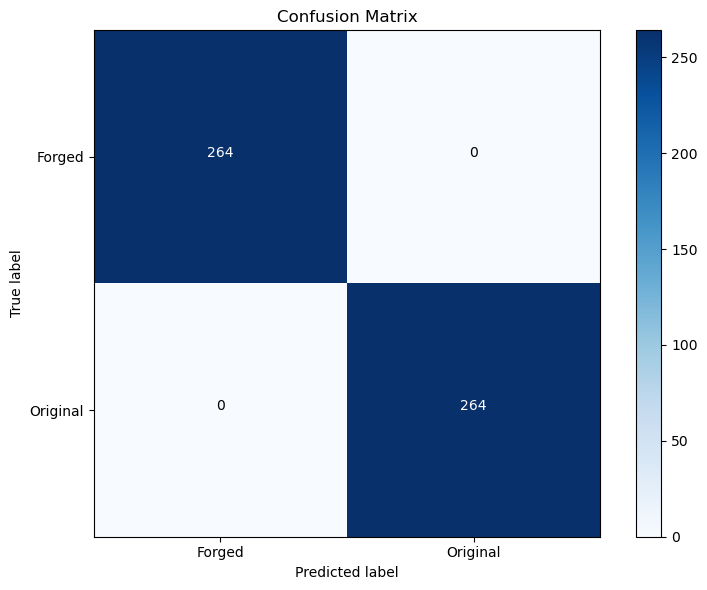


Displaying sample predictions:


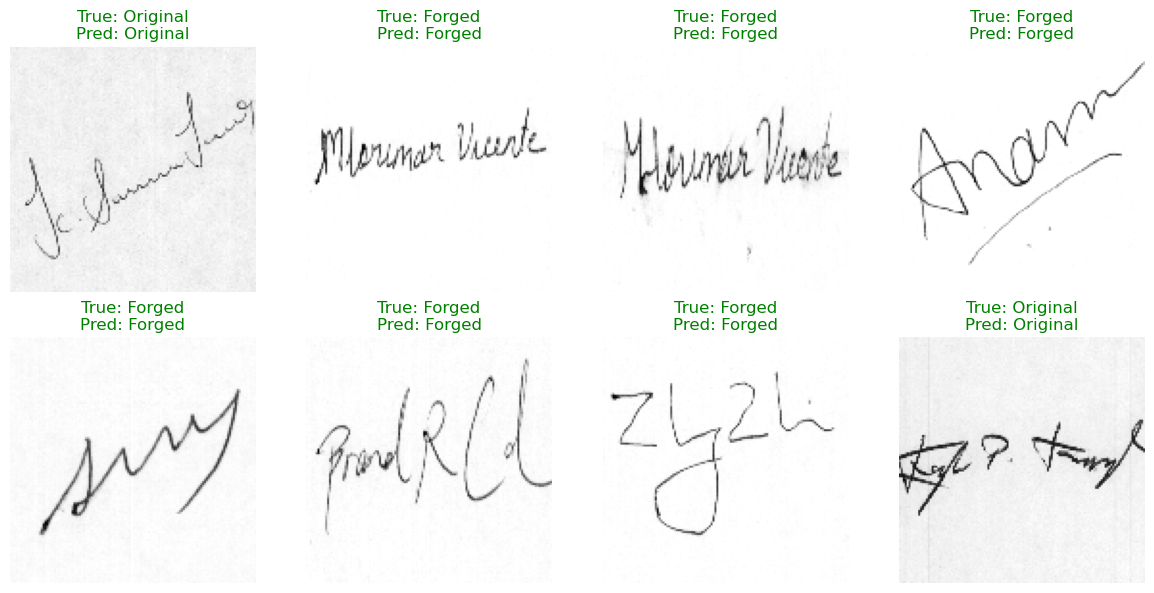


Model saved as 'signature_verification_ann_model.h5'

Summary of Evaluation Metrics:
Validation Accuracy: 1.0000
Validation Loss: 0.0014
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Equal Error Rate (EER): 0.0000

To test a single image, use:
test_single_image('path/to/your/signature.jpg')


In [ ]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

# Plot precision and recall
plt.subplot(1, 3, 3)
try:
    # First try with explicitly named metrics
    plt.plot(history.history['precision'], label='Precision')
    plt.plot(history.history['recall'], label='Recall')
    plt.plot(history.history['val_precision'], label='Val Precision')
    plt.plot(history.history['val_recall'], label='Val Recall')
except KeyError:
    # If that fails, try with the default Keras naming convention
    plt.plot(history.history.get('precision_1', []), label='Precision')
    plt.plot(history.history.get('recall_1', []), label='Recall')
    plt.plot(history.history.get('val_precision_1', []), label='Val Precision')
    plt.plot(history.history.get('val_recall_1', []), label='Val Recall')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.title('Precision & Recall')

plt.tight_layout()
plt.show()

# Evaluate the model on validation/test data
print("\nEvaluating model:")
val_loss, val_acc, val_precision, val_recall = model.evaluate(X_test, y_test, verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# Make predictions on validation set
y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype("int32")

# Calculate Precision, Recall and F1 score using sklearn directly for more control
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate Equal Error Rate (EER)
from sklearn.metrics import roc_curve

# Get false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calculate FRR (False Rejection Rate) = 1 - TPR
frr = 1 - tpr

# Find the threshold where FAR (FPR) and FRR are closest
eer_idx = np.argmin(np.abs(fpr - frr))
eer = (fpr[eer_idx] + frr[eer_idx]) / 2

print(f"Equal Error Rate (EER): {eer:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)
print("\nConfusion Matrix Interpretation:")
print(f"True Negatives (correctly identified forgeries): {cm[0, 0]}")
print(f"False Positives (forgeries classified as original): {cm[0, 1]}")
print(f"False Negatives (originals classified as forgeries): {cm[1, 0]}")
print(f"True Positives (correctly identified originals): {cm[1, 1]}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Forged', 'Original'])
plt.yticks(tick_marks, ['Forged', 'Original'])

# Add text annotations to the confusion matrix
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# Visualize some predictions
def display_prediction_samples(X_samples, y_true, y_pred, num_samples=8):
    # Find indices of both correct and incorrect predictions
    correct_indices = np.where(y_true == y_pred)[0]
    incorrect_indices = np.where(y_true != y_pred)[0]

    # Select samples
    samples_to_show = []

    # Add some incorrect predictions if available
    if len(incorrect_indices) > 0:
        n_incorrect = min(num_samples // 2, len(incorrect_indices))
        samples_to_show.extend(np.random.choice(incorrect_indices, n_incorrect, replace=False))

    # Fill the rest with correct predictions
    n_correct = num_samples - len(samples_to_show)
    if n_correct > 0 and len(correct_indices) > 0:
        samples_to_show.extend(np.random.choice(correct_indices, min(n_correct, len(correct_indices)), replace=False))

    # Display samples
    n_cols = 4
    n_rows = (len(samples_to_show) + n_cols - 1) // n_cols
    plt.figure(figsize=(n_cols * 3, n_rows * 3))

    for i, idx in enumerate(samples_to_show):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(X_samples[idx].reshape(image_size), cmap='gray')
        true_label = "Original" if y_true[idx] == 1 else "Forged"
        pred_label = "Original" if y_pred[idx] == 1 else "Forged"
        color = "green" if y_true[idx] == y_pred[idx] else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display some predictions
print("\nDisplaying sample predictions:")
display_prediction_samples(X_test, y_test, y_pred_classes)

# Save the model
model.save('signature_verification_ann_model.h5')
print("\nModel saved as 'signature_verification_ann_model.h5'")

# Print a summary of all metrics
print("\nSummary of Evaluation Metrics:")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Equal Error Rate (EER): {eer:.4f}")

# If you want to test a specific image
def test_single_image(image_path):
    # Load and preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Could not read image: {image_path}")
        return

    img = cv2.resize(img, image_size)
    img = img / 255.0
    img_flat = img.reshape(1, -1)  # Flatten and add batch dimension

    # Make prediction
    prediction = model.predict(img_flat)[0][0]
    pred_class = "Original" if prediction > 0.5 else "Forged"
    print(f"Image: {image_path}")
    print(f"Prediction: {pred_class} (confidence: {prediction:.4f})")

    # Display image with prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {pred_class}\nConfidence: {prediction:.4f}")
    plt.axis('off')
    plt.show()

    return prediction

print("\nTo test a single image, use:")
print("test_single_image('path/to/your/signature.jpg')")